### Mixture of Experts (MoE) Transformer with Llama4 type model 

Author: Tirth Shah  
Inspired by: https://github.com/FareedKhan-dev/train-llama4

#### Import Required Libraries and Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Import our custom modules
from model import MoETransformer, ModelConfig
from prepare_data import CharDataset
from train import TrainModel
import utils as utils

/home/tirth/git_personal/moe-experiments/model.py:89: SyntaxWarning: invalid escape sequence '\i'
  $$ \theta_i = \frac{1}{\rm{ropetheta}^{2i / d_k}} $$ where $i \in [0, 1, ..., d_k/2 - 1]$. We precompute `inv_freq` which corresponds to this $\theta_i$.


Set random seed for reproducibility

In [2]:
torch.manual_seed(42)

#### Prepare Dataset

Sample text from "Alice's Adventures in Wonderland". This is a small excerpt to keep the dataset manageable for demonstration purposes.

In [3]:
block_size = 64 # Define the block size for the dataset

dataset_path = "./dataset/alice_sample_dataset.pt"

text = """
    Alice was beginning to get very tired of sitting by her sister on the
    bank, and of having nothing to do: once or twice she had peeped into the
    book her sister was reading, but it had no pictures or conversations in
    it, 'and what is the use of a book,' thought Alice 'without pictures or
    conversation?'
    So she was considering in her own mind (as well as she could, for the
    hot day made her feel very sleepy and stupid), whether the pleasure
    of making a daisy-chain would be worth the trouble of getting up and
    picking the daisies, when suddenly a White Rabbit with pink eyes ran
    close by her.
    """

dataset = CharDataset(text=text, block_size=block_size) # Create dataset
torch.save(dataset, dataset_path) # save the dataset

#### Initialize MoE Transformer Model

In [4]:
# Model configuration
model_config = ModelConfig(
    d_model=128, 
    n_layers=4,
    n_heads=4,
    block_size=block_size,
    vocab_size=dataset.tokenizer.vocab_size,
    rms_norm_eps=1e-5,
    rope_theta=10000.0,
    num_local_experts=4,
    num_experts_per_tok=2,
    intermediate_size_expert=256,
    intermediate_size_shared=256
)

# Initialize the model
model = MoETransformer(config=model_config)
model = model.to(model.config.device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model initialized successfully!
Total parameters: 2,240,128
Trainable parameters: 2,240,128


#### Train the Model

Setting up training configuration

In [5]:
train_model = TrainModel(
    model=model,
    batch_size=16,
    learning_rate=5e-4,
    epochs=3000, # 3000 epochs
    print_interval=300,
    datadir=dataset_path,
    test_split=0.1
)

Training the model

Starting training...


 10%|█         | 302/3000 [00:14<02:11, 20.58it/s]

  Epoch 300/3000, Loss: 0.0637


 20%|██        | 602/3000 [00:29<01:56, 20.61it/s]

  Epoch 600/3000, Loss: 0.0730


 30%|███       | 902/3000 [00:44<01:41, 20.62it/s]

  Epoch 900/3000, Loss: 0.0670


 40%|████      | 1202/3000 [00:58<01:27, 20.62it/s]

  Epoch 1200/3000, Loss: 0.0597


 50%|█████     | 1502/3000 [01:13<01:12, 20.64it/s]

  Epoch 1500/3000, Loss: 0.0594


 60%|██████    | 1802/3000 [01:27<00:58, 20.63it/s]

  Epoch 1800/3000, Loss: 0.0634


 70%|███████   | 2102/3000 [01:42<00:43, 20.65it/s]

  Epoch 2100/3000, Loss: 0.0602


 80%|████████  | 2402/3000 [01:56<00:28, 20.64it/s]

  Epoch 2400/3000, Loss: 0.0588


 90%|█████████ | 2702/3000 [02:11<00:14, 20.62it/s]

  Epoch 2700/3000, Loss: 0.0619


100%|██████████| 3000/3000 [02:25<00:00, 20.59it/s]


  Epoch 3000/3000, Loss: 0.0520


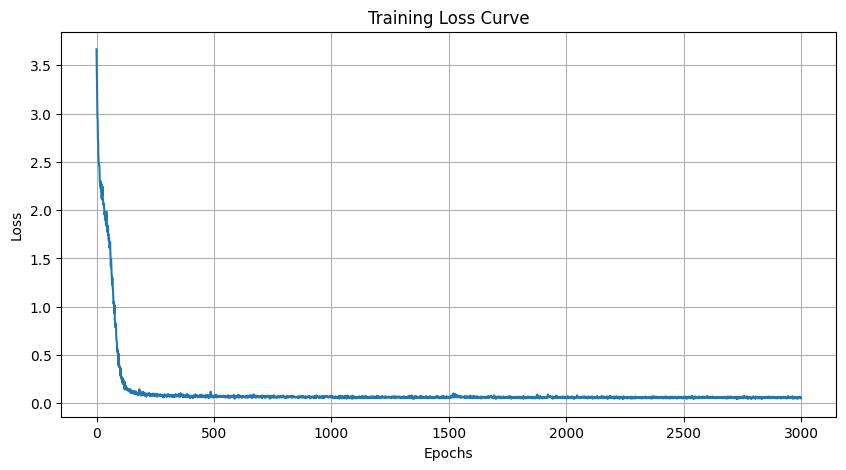

Training completed.
Final training loss: 0.0520


In [6]:
train_model.train()

print(f"Final training loss: {train_model.train_losses[-1]:.4f}")

#### Save the Model

In [7]:
utils.save_model(
    model=model,
    save_dir="./saved_models",
    save_name="moe_transformer.pth"
)

Model saved to ./saved_models/moe_transformer.pth


#### Generate some text using the trained model

In [8]:
model.generate(
    seed_text="Alice was beginning to get",
    tokenizer=dataset.tokenizer,
    max_new_tokens=100,
)

Generation loop finished.


'Alice was beginning to get very tired of sitting by her sister on the\n    bank, and of having nothing to do: once or twice she'